In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. Load Dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
# 2. Preprocess Data
train_images = train_images / 255.0
test_images = test_images / 255.0

In [4]:
# Reshape for CNN input if needed (e.g., adding channel dimension for grayscale)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# 3. Build the CNN Model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax') # 10 classes for Fashion MNIST
])

# 4. Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the Model
model.fit(train_images, train_labels, epochs=10)

# 6. Evaluate the Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# 7. Make Predictions (Optional)
predictions = model.predict(test_images)
# You can then interpret predictions for specific images

c:\Users\hari_\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8404 - loss: 0.4450
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8904 - loss: 0.3001
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9062 - loss: 0.2533
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9197 - loss: 0.2207
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9272 - loss: 0.1961
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9341 - loss: 0.1736
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9427 - loss: 0.1505
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9490 - loss: 0.1350
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9556 - loss: 0.1185
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9609 - loss: 0.1038
313/313 - 2s - 8ms/step - accuracy: 0.9113 - loss: 0.3110

Test accuracy: 0.911300003528595
313/313 ━━━━━━━

PROGRAM 2 : Building a simple gate that flags whether a product image is footwear or not. This is useful to route images to the right enrichment flow, power search refiners, and trigger footwear specific checks like size charts. Reusing Fashion MNIST as a stand in and map three classes to footwear sandal, sneaker, ankle boot and the rest to not footwear. Then train a compact CNN for a binary decision, track AUC and show a quick Grad CAM for interpretability.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,313 (427.00 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(0.7147498375568551), 1: np.float64(1.6641452344931922)}
Epoch 1/15
860/860 - 12s - 14ms/step - accuracy: 0.9655 - auc: 0.9949 - loss: 0.0904 - precision: 0.9255 - recall: 0.9626 - val_accuracy: 0.9936 - val_auc: 0.9988 - val_loss: 0.0259 - val_precision: 0.9807 - val_recall: 0.9980
Epoch 2/15
860/860 - 9s - 10ms/step - accuracy: 0.9936 - auc: 0.9993 - loss: 0.0211 - precision: 0.9844 - recall: 0.9944 - val_accuracy: 0.9956 - val_auc: 0.9991 - val_loss: 0.0143 - val_precision: 0.9932 - val_recall: 0.9919
Epoch 3/15
860/860 - 12s - 14ms/step - accuracy: 0.9952 - auc: 0.9995 - loss: 0.0151 - precision: 0.9884 - recall: 0.9958 - val_accuracy: 0.9924 - val_auc: 0.9986 - val_loss: 0.0229 - val_precision: 0.9774 - val_recall: 0.9973
Epoch 4/15
860/860 - 18s - 21ms/step - accuracy: 0.9957 - auc: 0.9994 - loss: 0.0140 - precision: 0.9890 - recall: 0.9967 - val_accuracy: 0.9964 - val_auc: 0.9991 - val_loss: 0.0115 - val_precision: 0.9906 - val_recall: 0.9973
Epoch 5

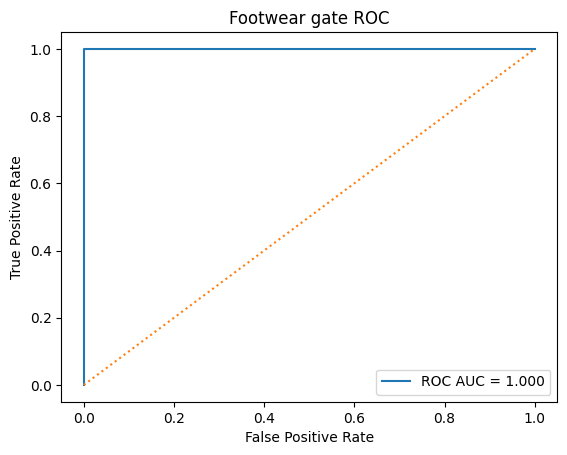

c:\Users\hari_\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_8']]
Received: inputs=['Tensor(shape=(1, 28, 28, 1))']
  warnings.warn(msg)


ModuleNotFoundError: No module named 'cv2'

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 1. Load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 2. Map to a binary label
# Footwear classes in Fashion MNIST: 5 sandal, 7 sneaker, 9 ankle boot
footwear_classes = {5, 7, 9}
train_binary = np.array([1 if lbl in footwear_classes else 0 for lbl in train_labels], dtype=np.int32)
test_binary  = np.array([1 if lbl in footwear_classes else 0 for lbl in test_labels],  dtype=np.int32)

# 3. Preprocess images
train_images = (train_images / 255.0)[..., np.newaxis]
test_images  = (test_images  / 255.0)[..., np.newaxis]

# 4. Build tf.data pipelines with a small validation split
batch_size = 64

# create a validation split from the tail of the training set
val_count = 5000
train_count = len(train_images) - val_count

train_ds = tf.data.Dataset.from_tensor_slices((train_images[:train_count], train_binary[:train_count]))
val_ds   = tf.data.Dataset.from_tensor_slices((train_images[train_count:],  train_binary[train_count:]))
test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_binary))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(AUTOTUNE)

# 5. Data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
], name="augment")

# 6. Model
inputs = keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(128, 3, activation="relu", padding="same", name="last_conv")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

# 7. Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

# 8. Class weights to offset any imbalance
pos = np.sum(train_binary[:train_count] == 1)
neg = np.sum(train_binary[:train_count] == 0)
total = pos + neg
class_weight = {
    0: total / (2.0 * neg),
    1: total / (2.0 * pos),
}
print("Class weights:", class_weight)

# 9. Train with early stopping
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

# 10. Evaluate
eval_res = model.evaluate(test_ds, verbose=2)
print("\nTest results:")
for name, val in zip(model.metrics_names, eval_res):
    print(f"{name}: {val:.4f}")

# 11. Thresholded predictions and confusion matrix
y_prob = model.predict(test_ds).ravel()
y_true = test_binary
y_pred = (y_prob >= 0.5).astype(np.int32)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2).numpy()
tn, fp, fn, tp = cm.ravel()
print("\nConfusion matrix:")
print(cm)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
print(f"Precision: {precision:.4f}  Recall: {recall:.4f}")

# 12. ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle=":")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Footwear gate ROC")
plt.legend(loc="lower right")
plt.show()






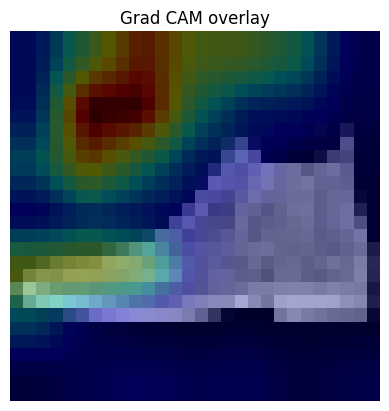

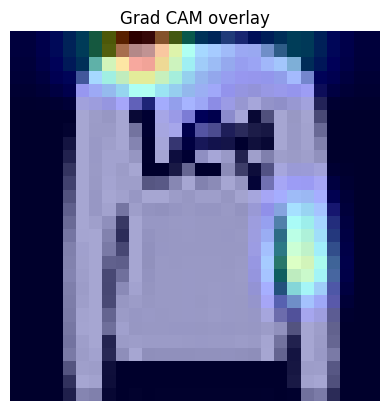

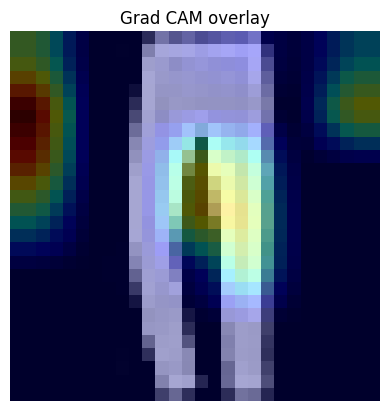

In [6]:
# 13. Simple Grad CAM to see what the model looks at
def grad_cam(img, model, conv_layer_name="last_conv"):
    # img shape: (1, 28, 28, 1) in [0,1]
    grad_model = keras.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(tf.cast(img, tf.float32), training=False)
        loss = preds[:, 0]  # positive class score
    grads = tape.gradient(loss, conv_out)                     # shape: (1, h, w, c)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)  # global average pooling over h,w
    cam = tf.reduce_sum(weights * conv_out, axis=-1)          # shape: (1, h, w)
    heatmap = cam[0]
    heatmap = tf.maximum(heatmap, 0)                          # ReLU
    heatmap /= (tf.reduce_max(heatmap) + 1e-9)                # normalize to [0,1]
    return heatmap.numpy()

def show_grad_cam(original_img, heatmap, alpha=0.35):
    # original_img shape: (28, 28, 1) in [0,1]
    base = np.squeeze(original_img)
    # resize heatmap to image size using TF
    heatmap_resized = tf.image.resize(
        heatmap[np.newaxis, ..., np.newaxis],
        (base.shape[0], base.shape[1]),
        method="bilinear"
    ).numpy().squeeze()

    plt.figure()
    plt.imshow(base, cmap="gray")
    plt.imshow(heatmap_resized, cmap="jet", alpha=alpha)
    plt.axis("off")
    plt.title("Grad CAM overlay")
    plt.show()

# pick a few test samples to visualize
for idx in [0, 1, 2]:
    sample = test_images[idx][np.newaxis, ...]
    hm = grad_cam(sample, model, conv_layer_name="last_conv")
    show_grad_cam(test_images[idx], hm)